In [1]:
import pandas as pd
import os

DATA_PATH = "../data/processed/stroke_data_processed.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,False,True,False,...,False,True,False,False,False,True,False,True,False,False
1,51676,61.0,0,0,202.21,28.1,1,True,False,False,...,False,False,True,False,True,False,False,False,True,False
2,31112,80.0,0,1,105.92,32.5,1,False,True,False,...,False,True,False,False,True,False,False,False,True,False
3,60182,49.0,0,0,171.23,34.4,1,True,False,False,...,False,True,False,False,False,True,False,False,False,True
4,1665,79.0,1,0,174.12,24.0,1,True,False,False,...,False,False,True,False,True,False,False,False,True,False


Hello
start
end
[DATA] Train: (4088, 21), Test: (1022, 21)
[MODELS] Pipelines created: ['logreg', 'rf', 'xgb']

[CV] Running stratified 5-fold CV (ROC AUC)
  - logreg: mean_auc=0.8387 | folds: 0.8251, 0.8540, 0.8311, 0.8331, 0.8500
  - rf: mean_auc=0.7972 | folds: 0.8085, 0.8144, 0.8080, 0.7800, 0.7753
  - xgb: mean_auc=0.8275 | folds: 0.8227, 0.8609, 0.8310, 0.8362, 0.7867

[SELECT] Best model: logreg (mean AUC=0.8387)

[Test Eval] (threshold=0.50)
  ROC AUC: 0.8438
  Precision: 0.1379  Recall: 0.8000  F1: 0.2353

Classification report:
               precision    recall  f1-score   support

           0     0.9863    0.7428    0.8474       972
           1     0.1379    0.8000    0.2353        50

    accuracy                         0.7456      1022
   macro avg     0.5621    0.7714    0.5414      1022
weighted avg     0.9448    0.7456    0.8175      1022

Confusion matrix:
 [[722 250]
 [ 10  40]]


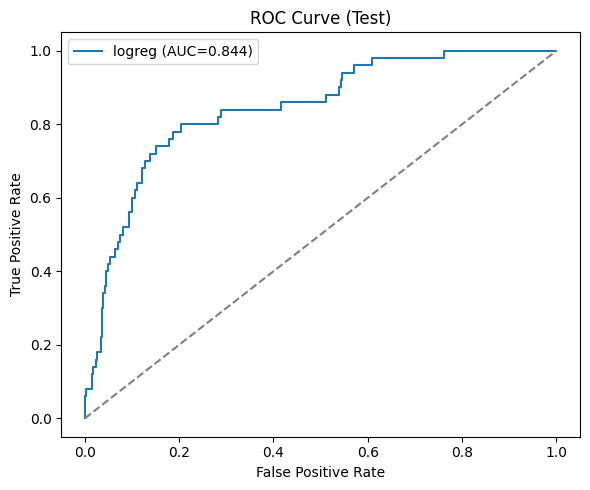


[SAVE] Best pipeline saved to: c:\Users\moham\OneDrive\Desktop\ML_Learnings\ai-healthcare-system\models\model.pkl


c:\Users\moham\OneDrive\Desktop\ML_Learnings\ai-healthcare-system\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[SHAP] Running for XGBoost...

[SHAP] Top 5 features:
                   feature  mean_abs_shap
                  num__age       2.156716
                  num__bmi       0.578228
    num__avg_glucose_level       0.360103
         num__hypertension       0.118076
cat__ever_married_No_False       0.086480


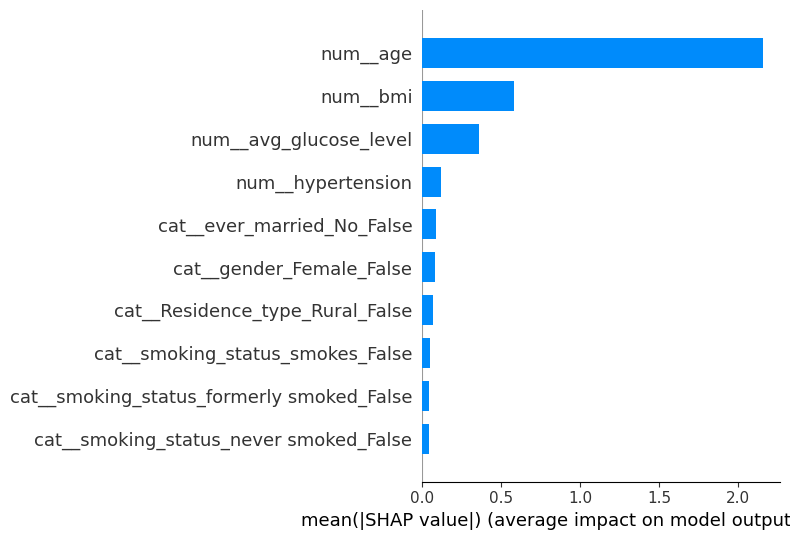

In [ ]:
#train and evaluare
# this ensures the prjoect root directory
import os, sys
PROJECT_ROOT = os.path.abspath("..") 
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)



from src.models.trainer import train_and_eval

results = train_and_eval()

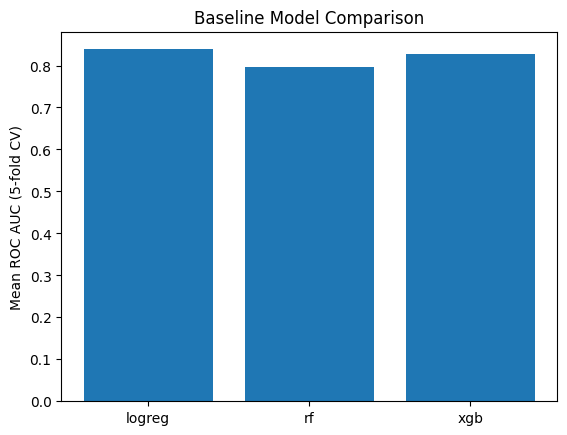

In [ ]:
# visualize for each model
import matplotlib.pyplot as plt

cv_results = results["cv_results"]

# Bar plot for mean AUC
names = list(cv_results.keys())
means = [cv_results[m]["mean_auc"] for m in names]

plt.bar(names, means)
plt.ylabel("Mean ROC AUC (5-fold CV)")
plt.title("Baseline Model Comparison")
plt.show()


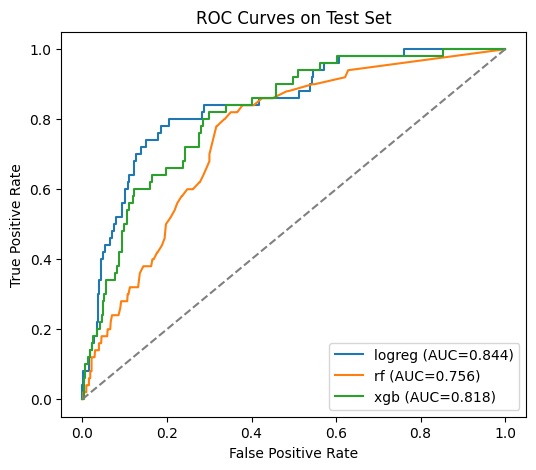

In [ ]:
# visualzie roc curve for each model
from sklearn.metrics import roc_curve, roc_auc_score
from src.models.baseline import build_preprocessor, build_pipelines
from sklearn.model_selection import train_test_split

X = df.drop(columns=["stroke", "id"], errors="ignore")
y = df["stroke"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

pre, _, _ = build_preprocessor(df, target="stroke")
pipes = build_pipelines(pre, random_state=42)

plt.figure(figsize=(6,5))
for name, pipe in pipes.items():
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curves on Test Set")
plt.show()


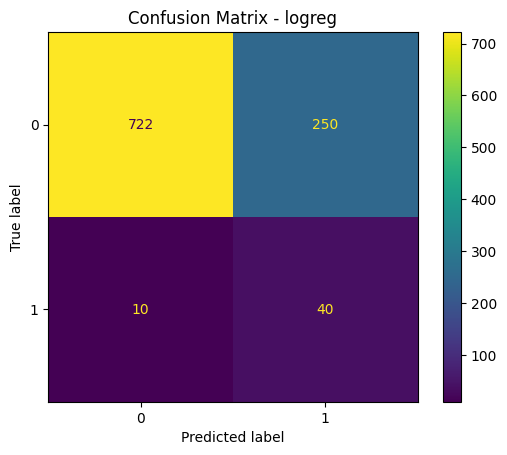

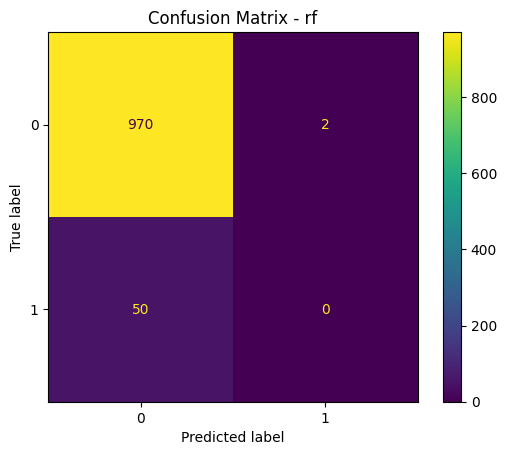

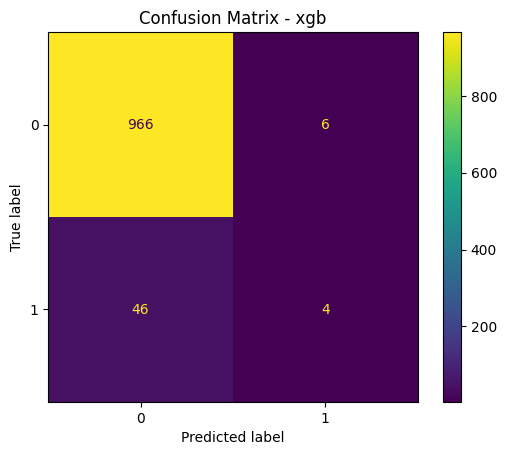

In [7]:
#confusuion matrices for each model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

for name, pipe in pipes.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


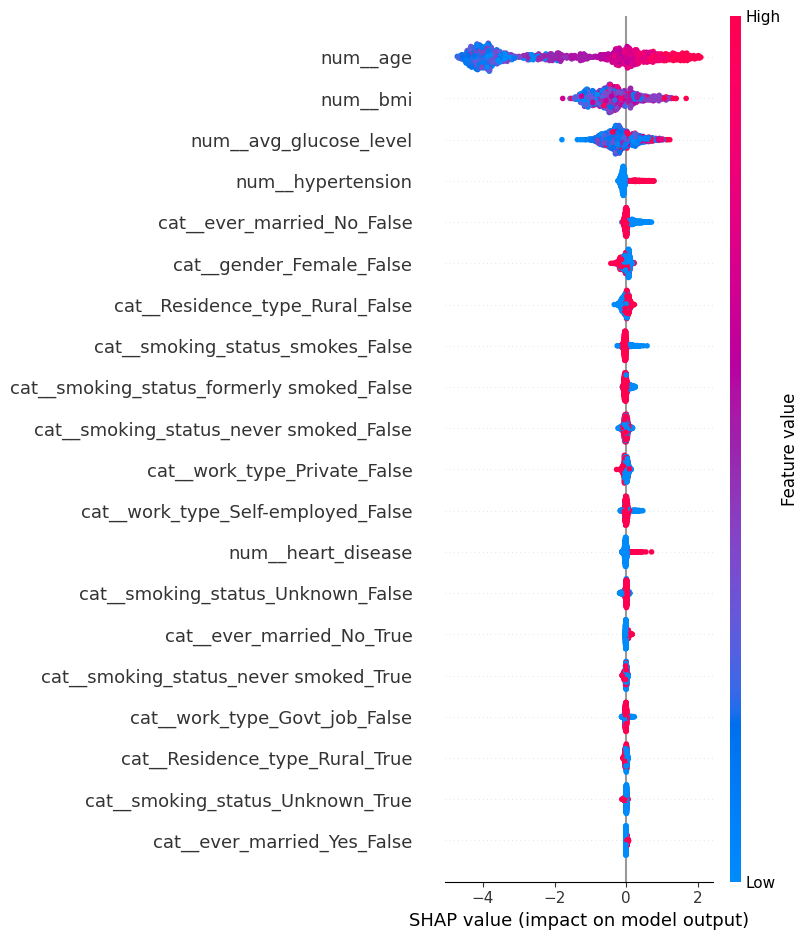

In [8]:
import shap

xgb_pipe = pipes["xgb"]
xgb_pipe.fit(X_train, y_train)
X_test_tx = pre.transform(X_test)

explainer = shap.TreeExplainer(xgb_pipe.named_steps["clf"])
shap_values = explainer.shap_values(X_test_tx)

shap.summary_plot(shap_values, X_test_tx, feature_names=pre.get_feature_names_out())
